<a href="https://colab.research.google.com/github/akankshaH05/IITI-SoC-2022-GBoard-AI/blob/main/IITISoC_'22_GBoard_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link to dataset used: https://shorturl.at/cqvxZ

In [ ]:
%tensorflow_version 2.x 
from keras.preprocessing import sequence
import keras
import tensorflow as tf
import os
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Kindly download the dataset from link given above and upload here

path_to_file = list(files.upload().keys())[0]

Saving Wonder.txt to Wonder.txt


In [ ]:
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
print ('Length of text: {} characters'.format(len(text)))

Length of text: 390663 characters


In [ ]:
text=text.replace('\n', ' ') #replacing the newline character with space
vocab = sorted(set(text))

#Assigning indices to unique characters
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

def text_to_int(text):
  return np.array([char2idx[c] for c in text])

text_as_int = text_to_int(text)

In [ ]:
def int_to_text(ints):
  try:
    ints = ints.numpy()
  except:
    pass
  return ''.join(idx2char[ints])

In [ ]:
seq_length = 100  # length of sequence for a training example
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
def split_input_target(chunk):  # for the example: hello
    input_text = chunk[:-1]  # hell
    target_text = chunk[1:]  # ello
    return input_text, target_text  # hell, ello

dataset = sequences.map(split_input_target)  # we use map to apply the above function to every entry

In [ ]:
BATCH_SIZE = 64
VOCAB_SIZE = len(vocab)  # VOCAB_SIZE is number of unique characters
EMBEDDING_DIM = 256
RNN_UNITS = 1024

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

data = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
    tf.keras.layers.Dense(vocab_size),
  ])
  return model

model = build_model(VOCAB_SIZE,EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (64, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (64, None, 1024)          5246976   
                                                                 
 dense (Dense)               (64, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [ ]:
history = model.fit(data, epochs=130, callbacks=[checkpoint_callback])

Epoch 1/130
60/60 [==============================] - 10s 65ms/step - loss: 3.0621 - accuracy: 0.2106
Epoch 2/130
60/60 [==============================] - 4s 64ms/step - loss: 2.4040 - accuracy: 0.3353
Epoch 3/130
60/60 [==============================] - 4s 65ms/step - loss: 2.1199 - accuracy: 0.4022
Epoch 4/130
60/60 [==============================] - 4s 66ms/step - loss: 1.9177 - accuracy: 0.4566
Epoch 5/130
60/60 [==============================] - 4s 66ms/step - loss: 1.7376 - accuracy: 0.5004
Epoch 6/130
60/60 [==============================] - 4s 66ms/step - loss: 1.6099 - accuracy: 0.5342
Epoch 7/130
60/60 [==============================] - 4s 67ms/step - loss: 1.5107 - accuracy: 0.5607
Epoch 8/130
60/60 [==============================] - 4s 68ms/step - loss: 1.4312 - accuracy: 0.5825
Epoch 9/130
60/60 [==============================] - 5s 67ms/step - loss: 1.3683 - accuracy: 0.5985
Epoch 10/130
60/60 [==============================] - 5s 68ms/step - loss: 1.3141 - accuracy: 0.612

dict_keys(['loss', 'accuracy'])


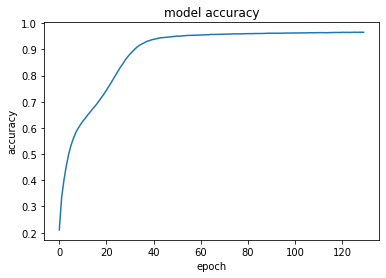

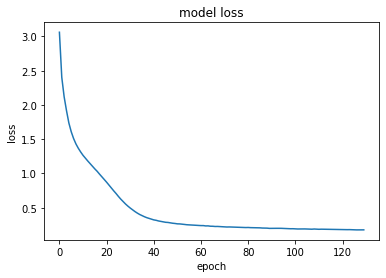

In [ ]:
print(history.history.keys())
# "Accuracy"
plt.plot(history.history['accuracy'])
##plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
##plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
##plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
##plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model1 = build_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, batch_size=1)

In [ ]:
model1.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model1.build(tf.TensorShape([1, None]))

model1.save("name1.h5")

In [ ]:
def generate_text(model, start_string):
  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 20

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated1 = []
  text_generated2 = []
  text_generated3 = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  #model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
    
      predictions = tf.squeeze(predictions, 0)
      

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated1.append(idx2char[predicted_id])

  #model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
    
      predictions = tf.squeeze(predictions, 0)
      

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated2.append(idx2char[predicted_id])

  #model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
      # remove the batch dimension
    
      predictions = tf.squeeze(predictions, 0)
      

      # using a categorical distribution to predict the character returned by the model
      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
    

      # We pass the predicted character as the next input to the model
      # along with the previous hidden state
      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated3.append(idx2char[predicted_id])

  #return (start_string + ''.join(text_generated1), start_string + ''.join(text_generated2), start_string + ''.join(text_generated3))
  return (text_generated1, text_generated2, text_generated3)

In [ ]:
inp = input("Type a starting string: ")
pred = list(generate_text(model1, inp))
print()

last = len(inp)-1



for i in range(len(pred)):
  if (inp[last]==' '):
    for j in range(len(pred[i])):
      if ((pred[i][j]==" ") and (j!=0)):
        break
      else:
        print(pred[i][j], end='')
  else:
    print(inp, end='')
    for j in range(len(pred[i])):
      if ((pred[i][j]==" ") and (j!=0)):
        break
      else:
        if (pred[i][j]==" " and j==0):
          continue
        else:
          print(pred[i][j], end='')


  print()
  print()

Type a starting string: hello 
do

le

ut

